In [1]:
import numpy as np
import ot
import cvxpy as cp
import matplotlib.pyplot as plt
import cv2

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
im1 = np.zeros([5,5])
im1[0,0] = 1
im2 = np.zeros([5,5])
im2[2,3] = 1

In [3]:
im2

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [4]:
def noise_image(im, noise_param = 1e-2):
    """takes an image and makes it noisy"""
    noisy_image = im
    height, width = im.shape
    for i in range(height):
        for j in range(width):
            noisy_image[i,j] += np.random.normal(0, noise_param)

    return noisy_image

### Steps:
1 - Normalize the images to have a certain sum

2 - Add noise to the images

3 - perform the optimal transport the way I just did above

4 - See the results with the use of $\tau$ and without it

In [5]:
im1_norm = im1/im1.sum()
im2_norm = im2/im2.sum()

In [6]:
im1_noisy = noise_image(im1_norm, 5e-2)
im2_noisy = noise_image(im2_norm, 5e-2)

In [7]:
def calculate_costs(size):
    """
    This function of an array or image and calculates the cost from it to itself.

    Parameters:
    - `size` (int or 2d array): representing the object on which we would like to calculate costs.

    Returns:
    - `costs` (numpy.ndarray): A 2D array representing the matrix of costs of transporting pixels
                                from the first image to the second image.
    """
    # TODO: Make this more efficient
    # 1D case:
    if type(size) == int:
        costs = np.zeros([size, size])
        m,n = int(np.sqrt(size)), int(np.sqrt(size))
        for i in range(m):
            for j in range(n):
                for k in range(m):
                    for l in range(n):
                        location_x = (i * n) + j
                        location_y = (k * n) + l
                        costs[location_x, location_y] += np.sqrt((i - k) ** 2 + (j - l) ** 2)
        return costs
    elif len(size) == 2:
        size_1d = size[0] * size[1]
        costs = np.zeros([size_1d, size_1d])
        m, n = size[0], size[1]
        for i in range(m):
            for j in range(n ):
                for k in range(m):
                    for l in range(n):
                        location_x = (i * n) + j
                        location_y = (k * n) + l
                        costs[location_x, location_y] += np.sqrt((i - k) ** 2 + (j - l) ** 2)
        return costs

In [8]:
C = calculate_costs(im1.shape)

In [9]:
def split_signed_measure(source: np.ndarray) -> (np.ndarray, np.ndarray):
    source_pos: np.ndarray = np.zeros(source.shape)
    source_neg: np.ndarray = np.zeros(source.shape)

    source_pos[source > 0] = source[source > 0]
    source_neg[source < 0] = -source[source < 0]

    return source_pos, source_neg

In [10]:
## To work with the signed measures
im1_pos, im1_neg = split_signed_measure(im1_noisy.flatten())
im2_pos, im2_neg = split_signed_measure(im2_noisy.flatten())

In [11]:
im1_new = (im1_pos + im2_neg).reshape(im1.shape)
im2_new = (im1_neg + im2_pos).reshape(im2.shape)

In [12]:
# im1_noisy[0,0] = -40  # This was used to show that getting a negative value does have effect, seems like plt.imshow normalizes the value automatically.
print('not in use')

not in use


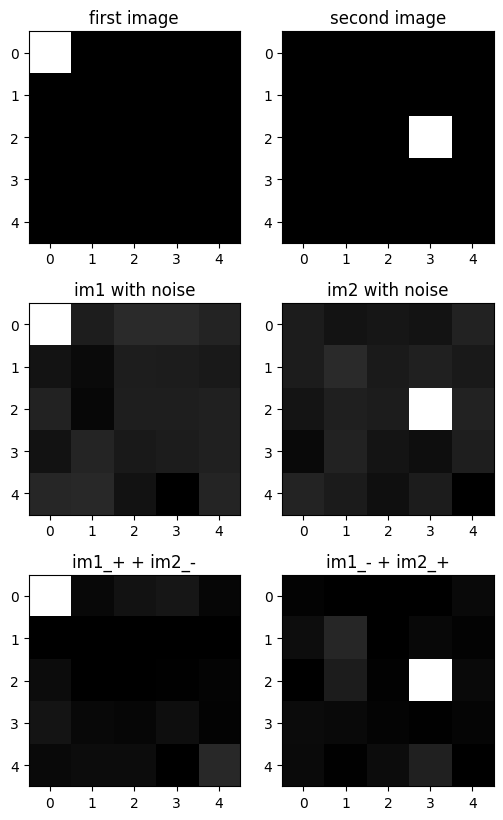

In [13]:
fig = plt.figure(figsize=(6, 10))

fig.add_subplot(3, 2, 1)
plt.title('first image')
plt.imshow(im1, cmap='gray')

fig.add_subplot(3, 2, 2)
plt.title('second image')
plt.imshow(im2, cmap='gray')

fig.add_subplot(3, 2, 3)
plt.title('im1 with noise')
plt.imshow(im1_noisy, cmap='gray')

fig.add_subplot(3, 2, 4)
plt.title('im2 with noise')
plt.imshow(im2_noisy, cmap='gray')

fig.add_subplot(3, 2, 5)
plt.title('im1_+ + im2_-')
plt.imshow(im1_new, cmap='gray')

fig.add_subplot(3, 2, 6)
plt.title('im1_- + im2_+')
plt.imshow(im2_new, cmap='gray')

In [14]:
im1_noisy.sum()

0.8254508167628759

In [15]:
im2_noisy.sum()

0.981169153093715

In [16]:
def kl_divergence_cp(p, q):
    return cp.sum(cp.multiply(p, cp.log(p / q)))

def TV_distance_cp(p, q):
    return cp.max(cp.abs(p-q))

def create_constraints(source, target):
    T_matrix = cp.Variable((len(source), len(target)), nonneg=True)

    cons = [cp.sum(T_matrix, axis=0) == target,  # column sum should be what we move to the pixel the column represents
            cp.sum(T_matrix, axis=1) == source,  # row sum should be what we move from the pixel the row represents
            T_matrix >= 0]  # all elements of T_matrix should be non-negative

    return T_matrix, cons

def solve_unbalanced_ot(source, target, cost_matrix, tau_1 = 1, tau_2 = 1):
    p, constraints = create_constraints(source, target)

    tv_first = kl_divergence_cp(source, target)
    tv_second = kl_divergence_cp(source, target)

    obj = cp.Minimize(cp.sum(cp.multiply(p, cost_matrix)) + tau_1 * tv_first + tau_2 * tv_second)
    prob = cp.Problem(obj, constraints)
    prob.solve()
    return prob.value, p.value, source, target

### This is not working since I'm trying to optmize on a and b instead of $\tilde{a}$, $\tilde{b}$. The formulation we have in the book is either:
1. $min_{\tilde{a},\tilde{b}}$ $L_C$ (ã,b̃) + $\tau_1$ Dᵩ(a,ã) + $\tau_2$ Dᵩ(b,b̃)
2. $min_{P \in R_+ ^{nxm}}$ <C,P> + $\tau_1$ Dᵩ($P$𝟙ₘ|a) + $\tau_2$ Dᵩ($P^T$ 𝟙ₘ|b)

I should try and implement the second option since I think it's easier. Get a grasp of what exactly $D_ϕ$ means

In [31]:
p_original, cons = create_constraints(im1.flatten(), im2.flatten())

In [32]:
obj = cp.Minimize(cp.sum(cp.multiply(p_original, C)))
prob_original = cp.Problem(obj, cons)
prob_original.solve()

3.60555127555594

In [33]:
original_plan = p_original.value

In [34]:
cp.sum(cp.multiply(p_original, C)).value

3.60555127555594

In [35]:
a = prob_original.value
a ** 2

13.000000000663066

In [36]:
im1_new_norm = im1_new / im1_new.sum()
im2_new_norm = im2_new / im2_new.sum()

In [37]:
p_new, cons = create_constraints(im1_new_norm.flatten(), im2_new_norm.flatten())

In [38]:
obj = cp.Minimize(cp.sum(cp.multiply(p_new, C)))
prob_new = cp.Problem(obj, cons)
prob_new.solve()

2.156752283969572

In [39]:
new_plan = p_new.value

In [40]:
im1_new.shape

(5, 5)

In [41]:
value, tran_plan, _, _ = solve_unbalanced_ot(source = im1_new.flatten(), target = im2_new.flatten(), cost_matrix = C)

C:\Users\eriki\AppData\Local\Temp\ipykernel_14324\1771336436.py:2: RuntimeWarning: divide by zero encountered in divide
  return cp.sum(cp.multiply(p, cp.log(p / q)))


In [44]:
type(p_original.value[0,0])

numpy.float64

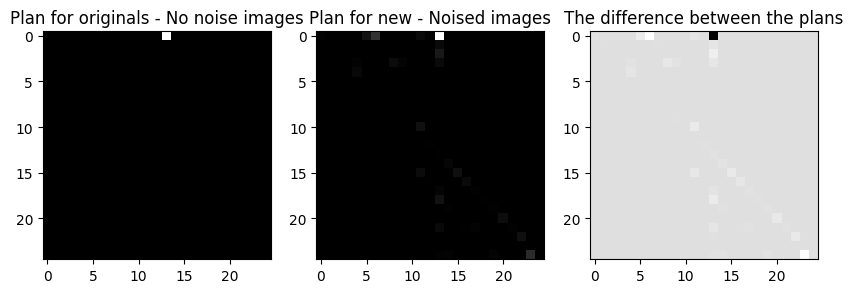

In [47]:
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1, 3, 1)
plt.title('Plan for originals - No noise images')
plt.imshow(original_plan, cmap='gray')

fig.add_subplot(1, 3, 2)
plt.title('Plan for new - Noised images')
plt.imshow(new_plan, cmap='gray')

fig.add_subplot(1, 3, 3)
plt.title('The difference between the plans')
plt.imshow(new_plan - original_plan, cmap='gray')

In [ ]:
res1 = ot.solve(M = C, a = im1.flatten(), b = im2.flatten())
ot_original_plan = res1.plan
ot_original_value = res1.value

In [ ]:
res2 = ot.solve(M = C, a = im1_new_norm.flatten(), b = im2_new_norm.flatten())
ot_new_plan = res2.plan
ot_new_value = res2.value

In [ ]:
fig = plt.figure(figsize=(10, 6))

#CVXPY
fig.add_subplot(2, 3, 1)
plt.title('Plan for originals')
plt.imshow(p_original.value, cmap='gray')

fig.add_subplot(2, 3, 2)
plt.title('Plan for new')
plt.imshow(p_new.value, cmap='gray')

normal_dif = p_new.value - p_original.value
fig.add_subplot(2, 3, 3)
plt.title('Diff')
plt.imshow(normal_dif, cmap='gray')

#OT.SOLVE
fig.add_subplot(2, 3, 4)
plt.title('Plan for originals')
plt.imshow(ot_original_plan, cmap='gray')

fig.add_subplot(2, 3, 5)
plt.title('Plan for new')
plt.imshow(ot_new_plan, cmap='gray')

ot_dif = ot_new_plan - ot_original_plan
fig.add_subplot(2, 3, 6)
plt.title('Diff')
plt.imshow(ot_dif, cmap='gray')

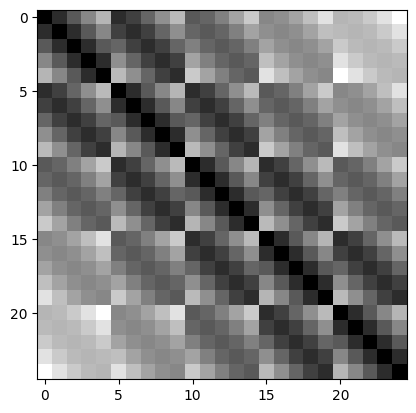

In [25]:
plt.imshow(C, cmap = 'gray')

In [ ]:
ot_original_value

3.605551275463989

In [ ]:
prob_original.value

3.60555127555594

## Addition from August

In [48]:
from utils.utils import unbalanced_sinkhorn

In [78]:
im2_new.min()

0.0

Since w ehave a lot of zeros, the calculation of the divergence fails. To handle that, I will try several approaches. 

1 - adding a smoothing parameter $\epsilon$ which we will add to both distributions

2 - ignoring the places where either of the distributions is 0. for the case where we optimize on P, all the zero values are known, therefore we could just ignore the places which have them for bboth divergences.

In [79]:
def create_d_phi(source: np.ndarray, target: np.ndarray, ro: float = 1.0, eps = 1e-6) -> cp.Variable:
    """
    Takes two probability distributions and calculates the KL divergence between them.
    :param source: The source distribution
    :param target: The target distribution
    :param ro: TODO: explain
    :param eps: This parameter decides how much smoothing there will be in case of zeros in the target measure
    :return: returns the variable d_phi as a cvxpy variable so that we could optimize on it
    """
    if target.min() == 0:
        print('The measure contains zero, a smoothing effect will be added.')
        target = target + eps
    D_phi = cp.Variable
    first_exp0 = cp.log(source/target)
    first_exp1 = cp.sum(cp.multiply(source/target, first_exp0))
    second_exp = cp.sum(source/target)
    D_phi = ro * cp.sum(first_exp1 - second_exp + 1)
    return D_phi

In [95]:
T_matrix = cp.Variable((len(im1_new.flatten()), len(im2_new.flatten())), nonneg=True)
cons = [T_matrix >= 0]  # all elements of T_matrix should be non-negative

In [96]:
T_matrix.shape

(25, 25)

In [97]:
ones = np.ones(len(im1_new.flatten()))
a = create_d_phi(T_matrix @ ones, im1_new.flatten())
b = create_d_phi(T_matrix.T @ ones, im2_new.flatten())

The measure contains zero, a smoothing effect will be added.
The measure contains zero, a smoothing effect will be added.


In [107]:
plan = ot.unbalanced.mm_unbalanced(a = im1_new.flatten(), b = im2_new.flatten(), M = C, reg_m = 1)

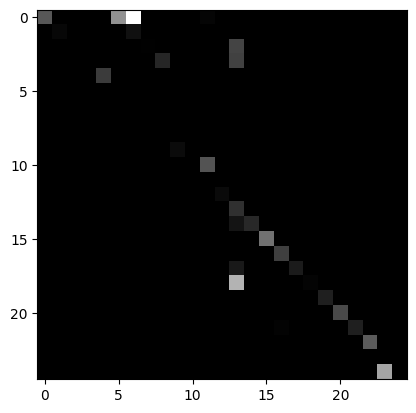

In [108]:
plt.imshow(plan, cmap='gray')

In [ ]:
tau_1 = 1
tau_2 = 1

obj = cp.Minimize(cp.sum(cp.multiply(T_matrix, C)) + tau_1 * a)
prob = cp.Problem(obj, cons)
prob.solve()